# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [26]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

from sklearn import decomposition

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

import math



### Define method to split training and testing set

In [2]:
# TODO: Manipulate test_ratio
def split_train_test(training_set, test_ratio = 0.33):
    row_count = training_set.shape[0]
    shuffled_indices = np.random.permutation(row_count)
    test_set_size = int(test_ratio * row_count)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return training_set.iloc[train_indices], training_set.iloc[test_indices]

### Load training set matrix

In [3]:
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_7_31_2018_1.csv")
labeled_matrix_training_set.columns.values[0] = "sampleId"
labels = list(range(1,6))


In [4]:
display(labeled_matrix_training_set.copy().head())

,sampleId,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin,1,4,6,8,...,43,44,45,46,47,48,49,50,52,53
0,hM17D,0.637520,0.652945,0.679371,0.822522,0.927028,-0.191476,-0.111982,-0.031535,0.194702,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
1,hM19A,0.744417,0.667870,0.563638,0.839585,0.874489,0.117598,0.049725,0.292631,-0.521739,...,0.126315,-0.115778,-0.407217,0.393595,0.052298,0.333852,0.468704,-0.387182,0.542903,-0.110980
2,hM19B,0.736595,0.697379,0.606223,0.909020,0.939280,-0.516071,-0.485236,0.178861,-0.645285,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
3,hM19C,0.672706,0.631027,0.590799,0.641945,0.924407,-0.494288,-0.585292,0.200625,-0.543859,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
4,hM19D,0.585682,0.614227,0.579178,0.583491,NaN,-0.548347,-0.512629,0.188757,-0.508282,...,0.105863,-0.005723,-0.486995,0.389744,-0.490257,0.341218,0.439575,-0.359887,0.544827,-0.097471


## Visualize ML Results

In [6]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

### Visualize ML results using Linear Regression

array([], dtype=int64)
RMSE: 0.140171587248
Pearson: (0.0022507465964751575, 0.99446109071028876)
Spearman: SpearmanrResult(correlation=-0.16783216783216784, pvalue=0.60209942778653802)


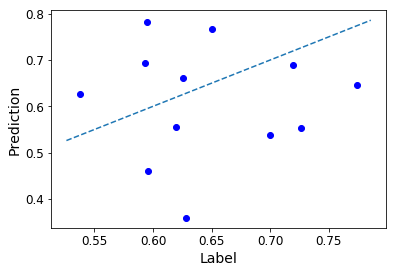

CV Scores: [ 0.5919706   0.04957723  0.52124521  0.48815937  0.49524239  0.64667652
  0.40760609  0.60511678  0.42637237 -0.43021062]
CV Mean: 0.380175592635
CV STD: 0.313079473097
array([], dtype=int64)
RMSE: 0.128645478737
Pearson: (0.29023977730752037, 0.36012082662383726)
Spearman: SpearmanrResult(correlation=0.19580419580419581, pvalue=0.54193588573131746)


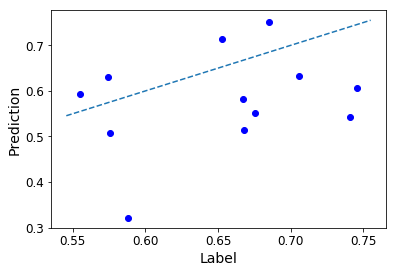

CV Scores: [ 0.53314051  0.55414799  0.24256738  0.47846053  0.46446113  0.46452697
  0.6093676   0.49631686  0.46232155  0.58414062]
CV Mean: 0.488945114022
CV STD: 0.0961972931622
array([], dtype=int64)
RMSE: 0.0962332715329
Pearson: (-0.068533024930942224, 0.83239623698680698)
Spearman: SpearmanrResult(correlation=-0.2797202797202798, pvalue=0.37856866966230307)


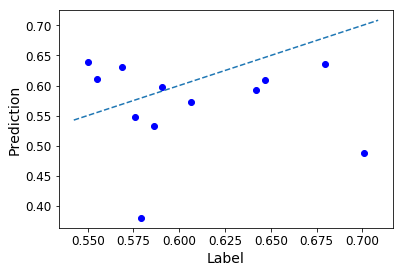

CV Scores: [ 0.40804564  0.45075456  0.47296947  0.50093083  0.55266248  0.40522978
  0.56578152  0.57577056  0.4508464   0.40178047]
CV Mean: 0.478477171306
CV STD: 0.0639266612933
array([], dtype=int64)
RMSE: 0.178021413877
Pearson: (-0.26604960839353503, 0.42908480199383259)
Spearman: SpearmanrResult(correlation=-0.35454545454545461, pvalue=0.2846927409558867)


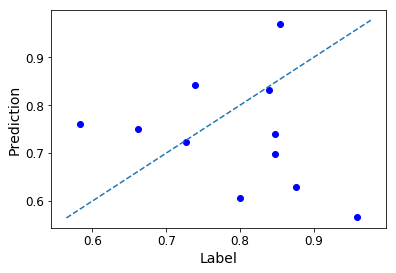

CV Scores: [ 0.18367524  0.56954526  0.56590263  0.50446744  0.73902241  0.16887398
  0.12517209  0.48913671  0.53707828  0.70534861]
CV Mean: 0.458822264062
CV STD: 0.210532165656
array([], dtype=int64)
RMSE: 0.109676823207
Pearson: (0.3492712119999844, 0.29242353057264464)
Spearman: SpearmanrResult(correlation=0.33636363636363636, pvalue=0.31182431390038623)


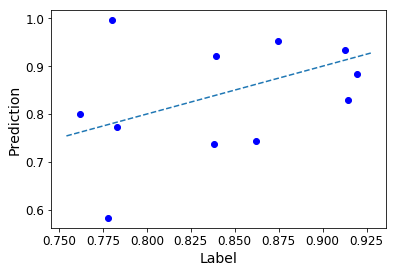

CV Scores: [ 0.40566482  0.64846531  0.61371099 -0.07396274 -0.23396148  0.11087107
  0.71280708  0.42330704  0.45439218  0.56143518]
CV Mean: 0.36227294487
CV STD: 0.305083736675


In [25]:
for label in labels:
    #
    # Select label column
    #
    selected_training_set = labeled_matrix_training_set.iloc[:, list([label]) + list(range(6,labeled_matrix_training_set.shape[1]))].copy()
    selected_training_set = selected_training_set[~np.isnan(selected_training_set.iloc[:,0])]
    #
    # Divide into training set and testing set
    #
    training_set, testing_set = split_train_test(selected_training_set, test_ratio = 0.33) # TODO: Use sklearn's train_test_split

    #
    # Get model training information and preprocess
    #
    model_data = training_set.copy().drop([training_set.columns[0]], axis = 1)
    model_labels = training_set.copy()[[training_set.columns[0]]]

    Ypipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     ('standardizer', StandardScaler()),
    ])

    model_labels_tr = Ypipeline.fit_transform(model_labels)

    XYpipeline = Pipeline([
            ('imputer', Imputer(axis=0,strategy="median")),
            ('standardizer', StandardScaler()),
            ('lasso_model', Ridge(alpha = 0.8))
    ])

    XYpipeline.fit(model_data, model_labels_tr)

    #
    # TODO: To prevent data leakage, separate the scope after the model has been fit
    #

    #
    # Get model testing information and preprocess
    #
    model_test_data = testing_set.copy().drop([testing_set.columns[0]], axis = 1)
    model_test_labels = testing_set.copy()[[testing_set.columns[0]]]

    model_test_labels_tr = Ypipeline.transform(model_test_labels)
    predictions = XYpipeline.predict(model_test_data)

    def imputer_inverse_transform(pre_data, post_data):
        na_indices = np.where(np.isnan(pre_data))[0]
        pprint(na_indices)
        post_data[na_indices] = float('NaN')
        return post_data


    predictions = Ypipeline.named_steps['standardizer'].inverse_transform(predictions)
    predictions = imputer_inverse_transform(model_test_labels, predictions)

    model_test_labels = model_test_labels.copy().values.flatten()
    model_test_labels = model_test_labels[~np.isnan(model_test_labels)]
    predictions = predictions[~np.isnan(predictions)]

    rmse = np.sqrt(mean_squared_error(model_test_labels, predictions))
    r = scipy.stats.pearsonr(model_test_labels, predictions)
    t = scipy.stats.spearmanr(model_test_labels, predictions)

    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    plt.plot(model_test_labels, predictions, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()

    scores = cross_val_score(XYpipeline, model_data, model_labels_tr,
                             scoring = "neg_mean_squared_error", cv=10)
    
    scores = Ypipeline.named_steps['standardizer'].inverse_transform(scores)
    
    print("CV Scores: " + str(scores))
    print("CV Mean: " + str(scores.mean()))
    print("CV STD: " + str(scores.std()))


### Visualize ML results using Random Forest Regressor

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([], dtype=int64)
RMSE: 0.0520121748069
Pearson: (0.50534177431441996, 0.093754246341197445)
Spearman: SpearmanrResult(correlation=0.25174825174825177, pvalue=0.42991878503288405)


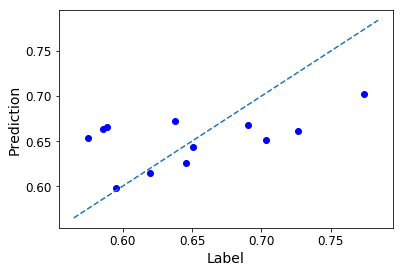

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([], dtype=int64)
RMSE: 0.0816804653971
Pearson: (-0.09628503749157323, 0.76595318512354882)
Spearman: SpearmanrResult(correlation=0.20979020979020982, pvalue=0.51284094318182627)


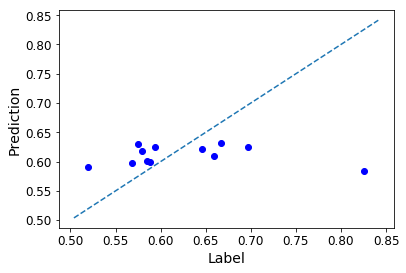

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([], dtype=int64)
RMSE: 0.0669065175455
Pearson: (-0.1704018502822871, 0.59646862103652876)
Spearman: SpearmanrResult(correlation=0.034965034965034975, pvalue=0.91409334241075979)


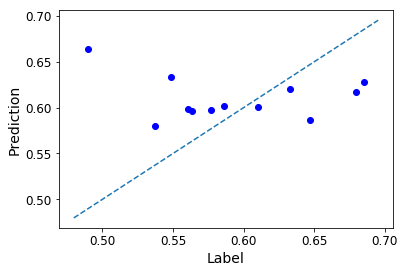

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([], dtype=int64)
RMSE: 0.121503787081
Pearson: (-0.019458234568724388, 0.95471716012897589)
Spearman: SpearmanrResult(correlation=-0.11818181818181818, pvalue=0.72928477951977999)


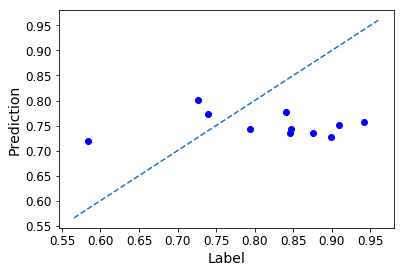

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([], dtype=int64)
RMSE: 0.0618995542533
Pearson: (0.32213426480168561, 0.33399521754132799)
Spearman: SpearmanrResult(correlation=0.27272727272727276, pvalue=0.41714143714253127)


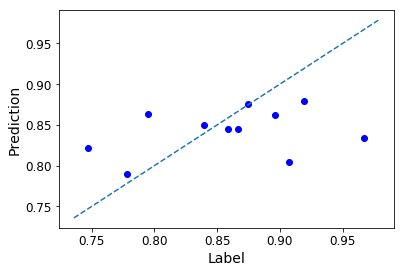

In [32]:
for label in labels:
    #
    # Select label column
    #
    selected_training_set = labeled_matrix_training_set.iloc[:, list([label]) + list(range(6,labeled_matrix_training_set.shape[1]))].copy()
    selected_training_set = selected_training_set[~np.isnan(selected_training_set.iloc[:,0])]
    #
    # Divide into training set and testing set
    #
    training_set, testing_set = split_train_test(selected_training_set, test_ratio = 0.33) # TODO: Use sklearn's train_test_split

    #
    # Get model training information and preprocess
    #
    model_data = training_set.copy().drop([training_set.columns[0]], axis = 1)
    model_labels = training_set.copy()[[training_set.columns[0]]]

    Ypipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     ('standardizer', StandardScaler()),
    ])

    model_labels_tr = Ypipeline.fit_transform(model_labels)

    XYpipeline = Pipeline([
            ('pca', decomposition.PCA(n_components=15)),
            ('imputer', Imputer(axis=0,strategy="median")),
            ('standardizer', StandardScaler()),
            ('rf_model', RandomForestRegressor(n_estimators=1000, max_leaf_nodes=16, n_jobs=4)) # TODO: For now, hardcore the parameters
    ])

    XYpipeline.fit(model_data, model_labels_tr)

    #
    # TODO: To prevent data leakage, separate the scope after the model has been fit
    #

    #
    # Get model testing information and preprocess
    #
    model_test_data = testing_set.copy().drop([testing_set.columns[0]], axis = 1)
    model_test_labels = testing_set.copy()[[testing_set.columns[0]]]

    model_test_labels_tr = Ypipeline.transform(model_test_labels)
    predictions = XYpipeline.predict(model_test_data)

    def imputer_inverse_transform(pre_data, post_data):
        na_indices = np.where(np.isnan(pre_data))[0]
        pprint(na_indices)
        post_data[na_indices] = float('NaN')
        return post_data


    predictions = Ypipeline.named_steps['standardizer'].inverse_transform(predictions)
    predictions = imputer_inverse_transform(model_test_labels, predictions)

    model_test_labels = model_test_labels.copy().values.flatten()
    model_test_labels = model_test_labels[~np.isnan(model_test_labels)]
    predictions = predictions[~np.isnan(predictions)]

    rmse = np.sqrt(mean_squared_error(model_test_labels, predictions))
    r = scipy.stats.pearsonr(model_test_labels, predictions)
    t = scipy.stats.spearmanr(model_test_labels, predictions)

    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    plt.plot(model_test_labels, predictions, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()

    #scores = cross_val_score(XYpipeline, model_data, model_labels_tr,
                             #scoring = "neg_mean_squared_error", cv=10)
    #scores = Ypipeline.named_steps['standardizer'].inverse_transform(scores)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))



